# 百度云/MEIZU 四则混合运算识别 深度学习应用大赛

## 初赛记录 Prototyping with CNN/CTC


- **Author**: Michael Yuan
- **Team**: 一朵小红花
- **Email**: mtyylx@163.com
- **Date**: 2017/Aug/2
- **Link**: http://meizu.baiducloud.top/ps/web/index.html
- **Training Data (Labeled)**: 100K Photos
- **Testing Data (Not Labeled)**: 200K Photos

# 环境配置

- 环境：Python 3.5 + TensorFlow 1.2.1 + Keras 2.0.2
- 模型：CNN + GRU + CTC

In [1]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import random
from time import time
from datetime import datetime

# 定义字符集

- 数字：10种
- 括号：2种
- 运算符：3种，不包括除法
- 空白符：1种，用来补齐没有使用括号的图片，这样所有图片中的字符串长度都可以统一固定为7。
    - 例如："1+7-1" （原长度为5）可以被识别为 "1+7-1\_\_" （长度为7）

In [2]:
# 字符集：去掉空格
char_set = '0123456789+-*() '

# 字符集长度 = 16
n_class = len(char_set)

# 图片所含文本内容的长度 = 7
n_len = 7

# 图片尺寸
width, height = 180, 60

# 数据预处理

### 1. 将训练数据序列化为Pickle文件

- 将训练数据的10万张图片序列化导出为10个Pickle文件。这样在后面训练时可以方便快速读取。
    - 每个文件是一个dict对象。
    - 该dict对象具有4个键
        - set_id：指示dict所含数据的批号
        - data：np.array，维度是(1000, 60, 180, 30)
        - expr：一万个文本表达式，与data的图像一一对应
        - res：一万个文本结果，与data的图像一一对应

In [ ]:
# 载入所有label信息，放入表达式（expression）和计算结果（result）这两个变量中
with open('.\image_contest_level_1\labels.txt', 'r') as f:
    labels = f.readlines()

# X = expr
# Y = result
x, y = [], []
for line in labels:
    splited = line.split(' ')
    x.append(splited[0])
    y.append(splited[1])
    
x_set = np.array(x).reshape(10, -1)
y_set = np.array(y).reshape(10, -1)

# 载入所有图片数据
img_db = []
for set_i in range(10):
    img_db.append([])
    for i in tqdm(range(10000)):
        img = Image.open('C:\\image_contest_level_1\\' + str(i + 10000 * set_i) + '.png').convert('RGB')
        img_db[set_i].append(np.array(img))

# 每10000张图片序列化为一个pickle文件
for i in tqdm(range(10)):
    obj = {'set_id':i, 'data':np.array(img_db[i]), 'expr':x_set[i], 'res':y_set[i]}
    with open('test_data_%s.p'%(i), 'wb') as f:
        pickle.dump(obj, f)

### 2. 载入Pickle文件

In [3]:
# 提供pickle文件所在位置，以及要取的数据集编号（0-9）
def load_dataset(set_id):
    if set_id > 9 or set_id < 0:
        print('Error: Invalid Dataset ID. Range 0 to 9.')
        return None
    with open('test_data_%s.p'%(set_id), mode='rb') as file:
        dataset = pickle.load(file)

    features = dataset['data']
    labels = np.array(dataset['expr'])
    results = np.array(dataset['res'])
#     print('Features Shape :', features.shape)
#     print('Expressions Shape :', labels.shape)
#     print('Results Shape :', results.shape)

    return features, labels, results

In [10]:
features, labels, results = load_dataset(0)

### 3. 预处理以满足CTC的需求

- 需要将横着的图片转置为竖着的图片，以供CTC切割为图像条，利于识别每个字符的特点。
- 需要指明输入和输出的相应维度
    - input_length: 指明预测值字符串的长度，相当于将图像分割为17段。
    - label_length: 指明实际值字符串的长度，这里统一强制为7.

In [11]:
# 将训练数据进行处理
def preprocess(features, labels, scan, test_mode=False):
    size = len(labels)
    x = np.array(features, dtype=np.uint8).transpose(0, 2, 1, 3)
    y = np.ones((size, n_len), dtype=np.uint8)
    if not test_mode:
        for i in range(size):
            tmp = labels[i]
            if len(tmp) < n_len:
                tmp = tmp + '  '
            y[i] = [char_set.find(ch) for ch in tmp]
    return [x, 
            y, 
            scan * np.ones(size),
            n_len * np.ones(size)], np.ones(size)

[x, y, _, _], _ = preprocess(features, labels, 17)
y[:5]

array([[13,  4, 12,  8, 14, 10,  8],
       [ 7, 10,  3, 12,  0, 15, 15],
       [ 5, 10, 13,  5, 10,  2, 14],
       [13,  8, 11,  0, 14, 11,  8],
       [ 0, 10, 13,  0, 10,  2, 14]], dtype=uint8)

# 模型训练

### 1. 定义模型

In [17]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [13]:
from keras.models import *
from keras.layers import *
from keras.layers.merge import Concatenate, Add
rnn_size = 128

def create_model_CTC(num_CCM, num_kernel):
    input_tensor = Input((width, height, 3))
    x = input_tensor
    
    # 卷积池化层
    for i in range(num_CCM):
        x = Conv2D(filters=num_kernel, kernel_size=3, strides=1, activation='relu')(x)
#         x = BatchNormalization()(x)
        x = Conv2D(filters=num_kernel, kernel_size=3, strides=1, activation='relu')(x)
#         x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
        
    # 全链接层
    conv_shape = x.get_shape()
    x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
    x = Dense(32, activation='relu')(x)
    
    # GRU层
    gru_1 = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
    gru_1b = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1_b', go_backwards=True)(x)
    gru1_merged = Add()([gru_1, gru_1b])
    
    gru_2 = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2_b', go_backwards=True)(gru1_merged)
    x = Concatenate()([gru_2, gru_2b])
    
    # Dropout层
    x = Dropout(0.25)(x)
    
    # 输出层：16类（字符集15类 + 空白符1类）
    x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
    
    # 基模型定义完成：卷积层 > 全链接 > GRU > Dropout > 输出层
    base_model = Model(inputs=input_tensor, outputs=x)
    
    # CTC层，输出CTC Loss
    labels = Input(name='the_labels', shape=[n_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    loss_out = Lambda(function=ctc_lambda_func, output_shape=[1], name='ctc')([x, labels, input_length, label_length])
    
    # CTC模型定义完成
    ctc_model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
    
    return conv_shape, base_model, ctc_model

### 2. 初始化模型

In [14]:
def loss_func(y_true, y_pred):
    return y_pred

In [15]:
# 1. 创建模型：3层卷积池化级联 / 32个卷积核
conv_shape, base_model, model = create_model_CTC(3, 32)

# 2. 编译模型
model.compile(loss={'ctc': loss_func}, optimizer='adadelta')
# model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')

In [16]:
print(conv_shape)

(?, 19, 4, 32)


In [ ]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="ctc_model.png", show_shapes=True)
Image('ctc_model.png')

### 3. 训练模型

In [18]:
from datetime import datetime
def get_time():
    return datetime.now().strftime("%Y%m%d@%H-%M-%S")

In [19]:
epoch = 1

In [367]:
total_dataset_to_be_trained = 10
batch_size = 64
import random

for set_id in range(total_dataset_to_be_trained):
    print("Training Data Set #", set_id)
    features, labels, results = load_dataset(set_id)
    scan = int(conv_shape[1] - 2)
    [x, y, I, L], T = preprocess(features, labels, scan)
    model.fit(x=[x, y, I, L], 
              y=T, 
              batch_size=batch_size, 
              epochs=1,
              callbacks=None)
    # 计算模型准确度
    acc = 100 * evaluate(model, size=10000, set_id=random.choice(range(10)))
    # 保存模型参数
    base_model.save('%s_ctc2_10set_%s_epoch_%s_acc.h5' % (get_time(), epoch, acc))
epoch += 1

Training Data Set # 0
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0039    
Accuracy over 10000 samples : 0.9985
Training Data Set # 1
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0152    
Accuracy over 10000 samples : 0.9996
Training Data Set # 2
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0039    
Accuracy over 10000 samples : 0.9991
Training Data Set # 3
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0073    
Accuracy over 10000 samples : 0.9977
Training Data Set # 4
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0109    
Accuracy over 10000 samples : 0.9978
Training Data Set # 5
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0051    
Accuracy over 10000 samples : 0.9984
Training Data Set # 6
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0109    
Accuracy over 10000 samples : 0.9986
Training Data Set # 7
Epoch

In [162]:
# 保存模型
base_model.save('arithmetic_ctc2_10set_4epoch_9984.h5')

In [21]:
# 查看当前模型所能达到的准确率
evaluate(model)

Accuracy over 10000 samples : 0.9986


0.99860000000000004

In [21]:
# 重新载入模型
from keras.models import load_model
base_model.load_weights('20170802@09-25-31_ctc2_10set_10_epoch_99.97_acc_test_129.h5')

### 4. 评估模型性能

In [22]:
# 使用第十个10000张图片计算测试准确率
def evaluate(model, size=10000, set_id=9):
    features, labels, results = load_dataset(set_id)
    scan = int(conv_shape[1] - 2)
    [X_test, y_test, _, _], _  = preprocess(features[:size], labels[:size], scan)
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = K.get_value(ctc_decode)[:, :n_len]
    batch_acc = 0
    for o in out:
        for i in range(len(o)):
            if o[i] == -1:
                o[i] = 15
    if out.shape[1] == n_len:
        batch_acc += ((y_test == out).sum(axis=1) == n_len).mean()
    print("Accuracy over %s samples :" % (size), batch_acc)
    return batch_acc

### 5. 可视化预测结果

In [23]:
# 检查预测结果解码情况
size = 10
features, labels, results = load_dataset(8)
scan = int(conv_shape[1] - 2)
[X_test, y_test, _, _], _  = preprocess(features[:size], labels[:size], scan)

# 使用CNN+GRU构成的基模型进行预测
y_pred = base_model.predict(X_test)
y_argmax = np.argmax(y_pred, axis=2)

shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
out = K.get_value(ctc_decode)[:, :n_len]

# 将-1恢复为空格15
for o in out:
    for i in range(len(o)):
        if o[i] == -1:
            o[i] = 15

print("id", "     ", "Original", "     ", "Predict", "    ", "CTC Code", "           ", "Correct?")
for i in range(size):
    pred = "".join([char_set[ch] for ch in out[i]])
    hard = "".join([char_set[ch] for ch in y_argmax[i]])
    correct = (labels[i] == pred.replace(" ", ""))
    print(i, "     ", labels[i], "     ", pred, "    ", hard, "    ", correct)            
            
batch_acc = 0
if out.shape[1] == n_len:
    batch_acc += ((y_test == out).sum(axis=1) == n_len).mean()
print("\nAccuracy over %s samples :" % (size), batch_acc * 100, "%")

id       Original       Predict      CTC Code             Correct?
0       (9*7)-4       (9*7)-4      (((99** 77)))--44        True
1       9-6+3       9-6+3        (99---66+  33            True
2       (9*6)-2       (9*6)-2      ((((99** 66)))--22       True
3       0-8-7       0-8-7        (00---88--777            True
4       (1+4)+3       (1+4)+3      (((11++ 44)))++  3       True
5       (6-2)-1       (6-2)-1      (((666--2)))--11         True
6       2-8-7       2-8-7        (22--888--777            True
7       1*(3*4)       1*(3*4)      ((1** ((3**  44))        True
8       9*6-2       9*6-2        (99** 666--22            True
9       1*(5*9)       1*(5*9)      ((1* (((555** 999))      True

Accuracy over 10 samples : 100.0 %


### 6. 汇总训练集中的识别错误图片

In [363]:
# 收集易错题，尝试进一步提高准确率
error_img = []
error_label = []

for set_id in range(10):
    size = 10000
    features, labels, results = load_dataset(set_id)
    scan = int(conv_shape[1] - 2)
    [X_test, y_test, _, _], _  = preprocess(features[:size], labels[:size], scan)

    # 预测和解码
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = K.get_value(ctc_decode)[:, :n_len]

    # 将-1恢复为空格15
    for o in out:
        for i in range(len(o)):
            if o[i] == -1:
                o[i] = 15

    for i in range(size):
        pred = "".join([char_set[ch] for ch in out[i]])
        if labels[i] != pred.replace(" ", ""):
            error_img.append(features[i])
            error_label.append(labels[i])

    batch_acc = 0
    if out.shape[1] == n_len:
        batch_acc += ((y_test == out).sum(axis=1) == n_len).mean()
    print("Accuracy over %s samples :" % (size), batch_acc * 100, "%")

print("Error Samples to be trained :", len(error_img))

Accuracy over 10000 samples : 99.99 %
Accuracy over 10000 samples : 99.94 %
Accuracy over 10000 samples : 100.0 %
Accuracy over 10000 samples : 99.99 %
Accuracy over 10000 samples : 99.97 %
Accuracy over 10000 samples : 99.98 %
Accuracy over 10000 samples : 99.95 %
Accuracy over 10000 samples : 99.97 %
Accuracy over 10000 samples : 99.91 %
Accuracy over 10000 samples : 99.94 %
Error Samples to be trained : 36


### 7. 对错误样本进行专题训练

In [204]:
err_features = np.array(error_img)
error_label = np.array(error_label)
scan = int(conv_shape[1] - 2)
[x, y, I, L], T = preprocess(err_features, error_label, scan)
model.fit(x=[x, y, I, L], 
          y=T, 
          batch_size=batch_size, 
          epochs=1, 
          verbose=1, 
          callbacks=None)
evaluate(model)

Epoch 1/1
176/176 [==============================] - 0s - loss: 0.4331     
Accuracy over 10000 samples : 0.9984


0.99839999999999995

# 扩展模型训练

> 经过对10万张训练图片将近10个Epoch的训练，准确率可以达到99.8%。为了进一步增强模型对于图像识别的泛化能力，尝试使用自动生成的captcha图像来进行扩展训练，这样的训练数据是无穷的。

### 1. 使用captcha生成器生成类似图片数据

- 使用catpcha库来生成训练图像，但是遇到的主要问题是生成的图像中字符的形态和原训练图像不一致。主要体现在减号的粗细上。
- 尝试用生成的图像训练，发现会把模型带跑偏，训练后的模型在原训练数据上的准确率反而下降了。
- 也许要自己修改captcha的代码才能产生更为相似的图片。

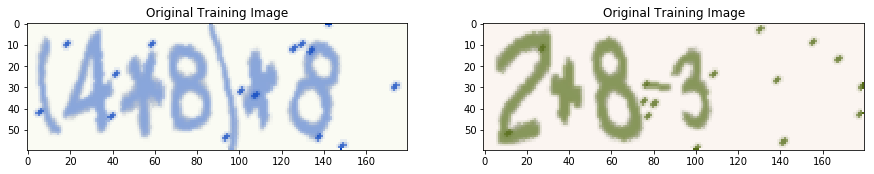

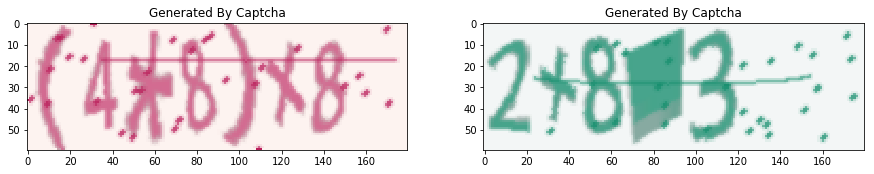

In [25]:
from captcha.image import ImageCaptcha

features, labels, _ = load_dataset(0)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(features[0])
plt.title("Original Training Image")
plt.subplot(122)
plt.imshow(features[11])
plt.title("Original Training Image")
plt.show()

generator = ImageCaptcha(180, 60)
plt.figure(figsize=(15, 5))
plt.subplot(121)
img = generator.generate_image("(4*8)+8 ")
plt.imshow(img)
plt.title("Generated By Captcha")
plt.subplot(122)
img = generator.generate_image("2+8-3  ")
plt.imshow(img)
plt.title("Generated By Captcha")
plt.show()

### 2. 运算式生成 + Captcha 图片生成器

In [26]:
# 运算式生成
def gen_expr():
    # 带括号模式（7）和不带括号模式（5）
    style = random.choice([5, 7])
    digits = [random.choice('0123456789') for i in range(3)]    # 三个数字
    operator = [random.choice('+*') for i in range(2)]         # 两个运算符
    out = ''
    if style == 5:
        out = digits[0] + operator[0] + digits[1] + operator[1] + digits[2] + '  '
    else:
        bracket = '(' + digits[0] + operator[0] + digits[1] + ')'
        side = random.choice([0, 1])
        if side == 0:
            out = digits[2] + operator[1] + bracket
        else:
            out = bracket + operator[1] + digits[2]
    return out

print(gen_expr())

0+(7+9)


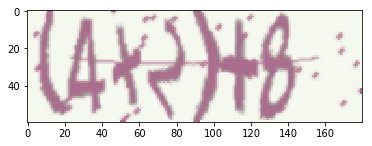

In [27]:
# 图片生成器
def gen_captcha(batch_size=64, scan=17):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height, font_sizes=[55])
        for i in range(batch_size):
            # 生成随机字符串：空格除外，固定长度为7
            random_str = gen_expr()
            # 图片转置后存入X
            X[i] = np.array(generator.generate_image(random_str+' ')).transpose(1, 0, 2)
            # 文本存入Y
            y[i] = [char_set.find(x) for x in random_str]
        # format: input = [x, labels, input_length, label_length], output = loss
        yield [X, 
               y, 
               np.ones(batch_size) * scan, 
               np.ones(batch_size) * n_len], np.ones(batch_size)
        
generator = gen_captcha()
[x, y, _, _], _ = next(generator)
plt.imshow(x[0].transpose(1, 0, 2))
plt.show()

### 3. Captcha 图片验证器

可以看到，训练出来准确率达到99.97%的模型，在生成图片上的识别率只有17%，说明泛化能力仍需提高。

In [35]:
def evaluate_captcha(model, batch_num=10):
    batch_acc = 0
    generator = gen_captcha()
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        # 使用CNN+GRU构成的基模型进行预测
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)[:, :n_len]
        for o in out:
            for i in range(len(o)):
                if o[i] == -1:
                    o[i] = 15

        for i in range(size):
            pred = "".join([char_set[ch] for ch in out[i]]).replace(" ", "")
            true = "".join([char_set[ch] for ch in y_test[i]]).replace(" ", "")
            print("True :", true, "    Pred :", pred)
            
        batch_acc += ((y_test == out).sum(axis=1) == n_len).mean()
    return batch_acc / batch_num

evaluate_captcha(model, 1)

True : 0*6+0     Pred : 1*5+1
True : 3*(0*7)     Pred : 3*(8*7)
True : 1+(3*4)     Pred : 1+(3*4)
True : 2+(3*5)     Pred : 2+(1*5)
True : 9*8+2     Pred : 9*8+2
True : (8*4)*3     Pred : (8*4)*3
True : 8+3*7     Pred : 6+3*1
True : (2*2)*9     Pred : (2*2)*9
True : 0+3*5     Pred : (+3*6
True : 9*4*8     Pred : 9*4*8-


0.1875

### 4. 进一步训练模型

In [272]:
from keras.callbacks import *
class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate_captcha(base_model)*100
        self.accs.append(acc)
        print(' <acc: %f%%>' % acc)
evaluator = Evaluate()

In [285]:
# the number of samples processed for each epoch is batch_size * steps_per_epochs
batch_size = 64
epoch = 1

# Training Set for one epoch
train_samples = 51200
train_steps = train_samples / batch_size

# Validation Set for one epoch
validation_sample = train_samples * 0.02
validation_steps = validation_sample / batch_size

# Start training
model.fit_generator(gen_captcha(batch_size), 
                    steps_per_epoch=train_steps, 
                    epochs=epoch, 
                    validation_data=gen_captcha(batch_size), 
                    validation_steps=validation_steps,
                    callbacks=[EarlyStopping(patience=10), evaluator])

Epoch 1/1
799/800 [============================>.] - ETA: 0s - loss: 0.3569

100%|████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


 <acc: 96.875000%>
800/800 [==============================] - 204s - loss: 0.3566 - val_loss: 0.1651


In [271]:
evaluate(model)

Accuracy over 10000 samples : 0.7575


0.75749999999999995

# 测试和提交

### 1. 对测试数据进行序列化

In [218]:
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# 导出为pickle
val_db = []
for set_i in range(20):
    val_db.append([])
    for i in tqdm(range(10000)):
        img = Image.open('C:\\image_contest_level_1_validate\\' + str(i + 10000 * set_i) + '.png').convert('RGB')
        val_db[set_i].append(np.array(img, dtype=np.uint8))
        
for i in tqdm(range(20)):
    obj = {'set_id':i, 'data':np.array(val_db[i])}
    with open('validation_data_%s.p'%(i), 'wb') as f:
        pickle.dump(obj, f)

100%|████████████████████████████████████████████████████████████| 20/20 [00:54<00:00,  2.18s/it]


In [36]:
# 导入pickle
def load_validation_dataset(set_id):
    if set_id > 19 or set_id < 0:
        print('Error: Invalid Dataset ID. Range 0 to 9.')
        return None
    with open('validation_data_%s.p'%(set_id), mode='rb') as file:
        dataset = pickle.load(file)
    features = dataset['data']

    return features

### 2. 使用模型对测试集进行预测并输出结果

In [37]:
from time import time
n_validation = 200000
batch = 10000
n_batch = 20

y_all_text = []
y_all_res = []
err_id = []

start = time()
for i_batch in range(20):
    # 从pickle文件导入
    features = load_validation_dataset(i_batch)
#     features, _, _ = load_dataset(i_batch)

    # Predict Using Trained Model
    scan = int(conv_shape[1] - 2)
    [X_test, _, _, _], _  = preprocess(features, _, scan, test_mode=True)
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = K.get_value(ctc_decode)[:, :n_len]
    for o in out:
        for i in range(len(o)):
            if o[i] == -1:
                o[i] = 15
    
    # Decode and store text expression
    y_text = []
    for i in range(batch):
        y_text.append("".join([char_set[ch] for ch in out[i]]))

    # Calculate the result of the expression
    y_res = []
    invalid_count = 0
    for i in tqdm(range(batch), desc="Calculating Batch #" + str(i_batch)):
        val = 0
        try:
            val = eval(y_text[i])
        except Exception as e:
            invalid_count += 1
            err_id.append(i + 10000 * i_batch)
#             print("Invalid Expression")
        y_res.append(val)
    print("Invalid Expression Count =", invalid_count)
    y_all_text += y_text
    y_all_res += y_res

print("Total Time:", time() - start)

Calculating Batch #0: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 76351.97it/s]


Invalid Expression Count = 8


Calculating Batch #1: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 67877.45it/s]


Invalid Expression Count = 3


Calculating Batch #2: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 69219.56it/s]


Invalid Expression Count = 4


Calculating Batch #3: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 69596.52it/s]


Invalid Expression Count = 5


Calculating Batch #4: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 74511.09it/s]


Invalid Expression Count = 8


Calculating Batch #5: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 72529.67it/s]


Invalid Expression Count = 7


Calculating Batch #6: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 76618.23it/s]


Invalid Expression Count = 6


Calculating Batch #7: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 71082.43it/s]


Invalid Expression Count = 10


Calculating Batch #8: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 74421.59it/s]


Invalid Expression Count = 7


Calculating Batch #9: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 74256.76it/s]


Invalid Expression Count = 4


Calculating Batch #10: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 70903.87it/s]


Invalid Expression Count = 5


Calculating Batch #11: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 74591.13it/s]


Invalid Expression Count = 8


Calculating Batch #12: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 72244.09it/s]


Invalid Expression Count = 4


Calculating Batch #13: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 74943.79it/s]


Invalid Expression Count = 6


Calculating Batch #14: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 71322.12it/s]


Invalid Expression Count = 8


Calculating Batch #15: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 76604.79it/s]


Invalid Expression Count = 8


Calculating Batch #16: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 75094.20it/s]


Invalid Expression Count = 7


Calculating Batch #17: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 68699.84it/s]


Invalid Expression Count = 7


Calculating Batch #18: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 75602.74it/s]


Invalid Expression Count = 8


Calculating Batch #19: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 74264.25it/s]


Invalid Expression Count = 6
Total Time: 274.3007607460022


In [ ]:
# Auto Correct - Hard to implement.
import string
def auto_correct(expr):
    pass

### 3. 检视未能识别为合法表达式的样本

In [38]:
print("Expressions:", len(y_all_text))
print("Results:", len(y_all_res))
print("Invalid Expressions:", len(err_id))
print("Check:", err_id)

Expressions: 200000
Results: 200000
Invalid Expressions: 129
Check: [629, 2246, 2271, 3307, 3412, 4129, 6090, 8739, 15442, 17416, 17578, 23354, 23472, 24909, 27017, 32292, 36607, 36977, 38968, 39560, 40302, 40437, 40650, 42630, 43173, 45036, 45476, 45951, 50177, 50420, 52262, 53804, 54442, 57661, 59634, 63192, 64077, 64866, 64899, 65631, 69932, 71857, 73642, 75255, 75606, 76148, 76333, 77631, 77940, 79048, 79878, 80070, 83089, 83197, 86012, 89047, 89639, 89655, 91934, 93565, 95303, 98483, 102187, 102901, 104573, 108195, 109476, 110926, 113831, 114631, 115334, 117227, 117422, 118579, 118977, 120826, 127500, 127878, 128519, 130028, 132147, 133746, 134777, 137252, 138336, 142660, 144337, 144391, 144772, 145647, 145902, 148485, 149439, 150454, 152054, 154308, 155061, 156747, 157208, 158085, 158378, 160481, 161366, 161974, 162500, 162828, 166891, 169081, 170164, 170305, 172413, 172637, 176011, 176755, 178119, 180241, 180602, 182392, 183693, 184223, 186284, 187691, 189038, 191266, 192277, 19

In [39]:
invalid_labels = [y_all_text[i] for i in err_id]
print(invalid_labels[:10])

['(+(+01)', '6-5)+2 ', '2+-(8-4', '(6*6*8 ', '(1*5)* ', '(2*1+5 ', '8-02*1 ', '7*6+*0 ', '0+9)-7 ', '((4+9) ']


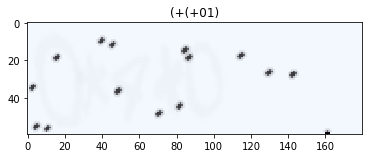

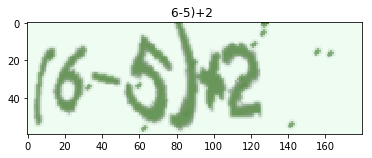

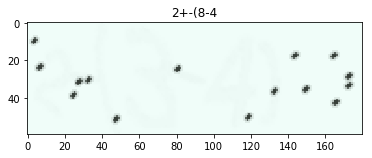

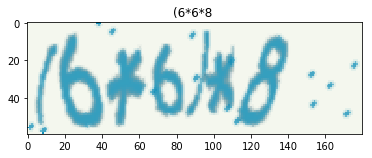

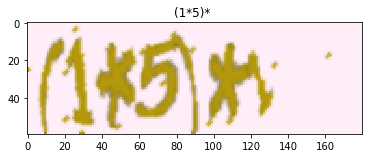

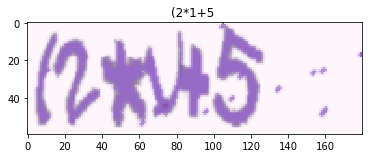

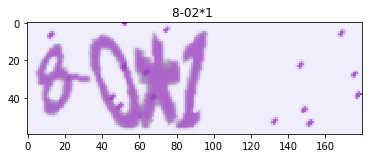

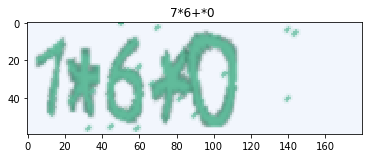

In [40]:
# err_id = [629, 2246, 2271, 3307, 3412, 4129, 6090, 8739, 15442, 17416, 17578, 23354, 23472, 24909, 27017, 32292, 36607, 36977, 38968, 39560, 40302, 40437, 40650, 42630, 43173, 45036, 45476, 45951, 50177, 50420, 52262, 53804, 54442, 57661, 59634, 63192, 64077, 64866, 64899, 65631, 69932, 71857, 73642, 75255, 75606, 76148, 76333, 77631, 77940, 79048, 79878, 80070, 83089, 83197, 86012, 89047, 89639, 89655, 91934, 93565, 95303, 98483, 102187, 102901, 104573, 108195, 109476, 110926, 113831, 114631, 115334, 117227, 117422, 118579, 118977, 120826, 127500, 127878, 128519, 130028, 132147, 133746, 134777, 137252, 138336, 142660, 144337, 144391, 144772, 145647, 145902, 148485, 149439, 150454, 152054, 154308, 155061, 156747, 157208, 158085, 158378, 160481, 161366, 161974, 162500, 162828, 166891, 169081, 170164, 170305, 172413, 172637, 176011, 176755, 178119, 180241, 180602, 182392, 183693, 184223, 186284, 187691, 189038, 191266, 192277, 192516, 195701, 196316, 198510]
x = load_validation_dataset(0)
for i in err_id:
    if i >= 10000:
        break
    plt.imshow(x[i])
    plt.title(y_all_text[i])
    plt.show()

- 可以看到，有些图片中的字符颜色相当浅，只能看到一些淡淡的水印，识别不出来也不奇怪。但绝大多数图片应该还有提高的余地。


### 4. 将结果合并导出为TXT以供提交上传

In [366]:
with open('ctc_validation_result_129.txt', 'w') as f:
    for i in tqdm(range(200000), desc='Write #' + str(i) + " to file"):
        line = str(y_all_text[i].replace(" ", "")) + ' ' + str(y_all_res[i]) + '\n'
        f.writelines(line)

Write #9999 to file: 100%|███████████████████████████| 200000/200000 [00:01<00:00, 117826.17it/s]


### 5. 提交结果记录

- `20170802@03-19-17_ctc2_10set_6_epoch_99.94_acc.h5` 达到151个无法解析的运算式。提交准确率为0.9997425 (总识别错误 515)
- `20170802@03-43-07_ctc2_10set_7_epoch_99.98_acc.h5` 达到136个无法解析的运算式。提交准确率为0.9998060 (总识别错误 388)
- `20170802@09-25-31_ctc2_10set_10_epoch_99.97_acc.h5` 达到129个无法解析的运算式。最终准确率为0.998350 (总识别错误 330)